In [514]:
from __future__ import division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential, load_model
from sklearn import preprocessing
from datetime import datetime, timedelta
import time

In [491]:
##### HELPERS #####
def prettify_ax(ax):
    ''' make an axis pretty '''
    for spine in ax.spines.itervalues():
        spine.set_visible(False)
    ax.set_frameon=True
    ax.patch.set_facecolor('#eeeeef')
    ax.grid('on', color='w', linestyle='-', linewidth=1)
    ax.tick_params(direction='out')
    ax.set_axisbelow(True)
    
def simple_ax(figsize=(6,4), **kwargs):
    ''' single prettified axis '''
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, **kwargs)
    prettify_ax(ax)
    return fig, ax

def earliest_date_after(query_date, date_list):
    ''' find the earliest date after a query date from ordered list of dates '''
    for i in range(len(date_list)):
        if query_date < date_list[i].date():
            return date_list[i].date()
    print '\nQUERY DATE ERROR WITH:', query_date, '\n'
    raise Exception('No values after query date')

def latest_date_before(query_date, date_list):
    ''' find the latest date before a query date from ordered list of dates '''
    for i in range(len(date_list)):
        if query_date < date_list[i].date():
            if i==0:
                print '\nQUERY DATE ERROR WITH:', query_date, '\n'
                raise Exception('No values before query date in list')
            return date_list[i-1].date()
        
def inv_price_transform(normalized_data, scaler):
    ''' inverse from normalized price to raw price '''
    m = scaler.mean_[0]
    s = scaler.scale_[0]
    return s*np.array(normalized_data)+m

# Load Data

In [492]:
def prep_data(ticker,
              stock_file = 'data/stock/prices-split-adjusted.csv', \
              news_directory = 'data/news/', \
              econ_file = 'data/market/economic_indicators.csv', \
              reddit_file = 'data/market/reddit_sentiments.csv'):
    ''' merge stock closing price data, sec filing data, and newspaper sentiment into one dataframe '''
    
    # load data
    stock_df = pd.read_csv(stock_file, index_col=0)
    stock_df = stock_df[stock_df.symbol==ticker].close
    stock_df.index = pd.to_datetime(stock_df.index)
    news_df = pd.read_csv(news_directory+ticker+'.csv', index_col=0)
    news_df.index = pd.to_datetime(news_df.index)
    econ_df = pd.read_csv(econ_file, index_col=0)
    econ_df.index = pd.to_datetime(econ_df.index)
    reddit_df = pd.read_csv(reddit_file, index_col=0).avg
    reddit_df.index = pd.to_datetime(reddit_df.index)
    return_df = pd.DataFrame(columns=[stock_df.name]+list(news_df.columns)+\
                             list(econ_df.columns)+[reddit_df.name])
    
    # clip price data that doesn't have news coverage or reddit coverage
    d0, d1 = news_df.index[0].date(), news_df.index[1].date()
    startdate, enddate = d0-(d1-d0), reddit_df.index[-2].date()
    stock_df = stock_df.loc[startdate:enddate]
    
    # iterate through rows, aggregating all data and appending to return_df
    for row_num in range(stock_df.shape[0]):
        new_row = []
        stock_date = stock_df.index[row_num].date()
        new_row += [stock_df.iloc[row_num]]
        new_row += list(news_df.loc[earliest_date_after(stock_date, news_df.index),:])
        new_row += list(econ_df.loc[latest_date_before(stock_date, econ_df.index),:])
        new_row += [reddit_df.loc[earliest_date_after(stock_date, reddit_df.index)]]
        return_df.loc[stock_date] = new_row
        if row_num % 100 == 0:
            print "%i/%i rows done." % (row_num, stock_df.shape[0]),
    print "%s dataframe prepped." % ticker
    return return_df

# practice with AAPL stock data
aapl_df = prep_data('AAPL')

0/1255 rows done. 100/1255 rows done. 200/1255 rows done. 300/1255 rows done. 400/1255 rows done. 500/1255 rows done. 600/1255 rows done. 700/1255 rows done. 800/1255 rows done. 900/1255 rows done. 1000/1255 rows done. 1100/1255 rows done. 1200/1255 rows done. AAPL dataframe prepped.


In [493]:
def load_stock(df, lookback=25):
    ''' scale data and split into training/test sets '''
    data = aapl_df.values
    n_train = list(aapl_df.index).index(aapl_df.index[-1]+timedelta(-365))
    scaler = preprocessing.StandardScaler() #normalize mean-zero, unit-variance
    scaler.fit(data[:n_train,:])
    data = scaler.transform(data)
    dataX, dataY = [], []
    for timepoint in range(data.shape[0]-lookback):
        dataX.append(data[timepoint:timepoint+lookback,:])
        dataY.append(data[timepoint+lookback,0])
    X_train, X_test = dataX[:n_train], dataX[n_train:]
    y_train, y_test = dataY[:n_train], dataY[n_train:]
    return np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test), scaler

# load practice stock, AAPL
lookback = 25
X_train, y_train, X_test, y_test, scaler = load_stock(df=aapl_df, lookback=lookback)

1002 training examples, 228 test examples


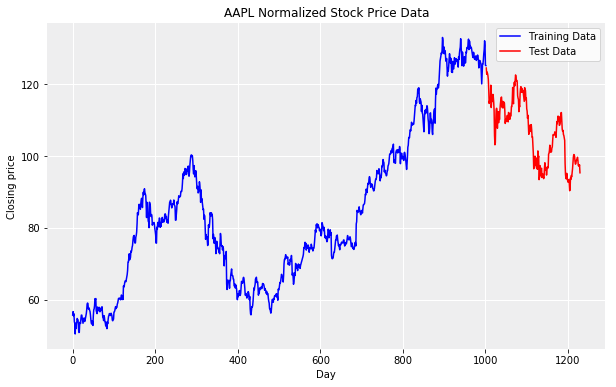

In [499]:
print "%i training examples, %i test examples" % (len(y_train), len(y_test))

f,a = simple_ax(figsize=(10,6))
a.plot(range(len(y_train)), inv_price_transform(y_train, scaler), c='b', label='Training Data')
a.plot(range(len(y_train),len(y_test)+len(y_train)), inv_price_transform(y_test, scaler), c='r', label='Test Data')
a.set_title('AAPL Normalized Stock Price Data')
a.set_xlabel('Day')
a.set_ylabel('Closing price')
plt.legend()
plt.show()

# Train LSTM RNN

In [519]:
# build model
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1],X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.2))
#model.add(Dense(32, kernel_initializer="uniform", activation='relu'))        
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='rmsprop')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 25, 128)           70144     
_________________________________________________________________
dropout_19 (Dropout)         (None, 25, 128)           0         
_________________________________________________________________
lstm_20 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dropout_20 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 129       
Total params: 201,857
Trainable params: 201,857
Non-trainable params: 0
_________________________________________________________________


In [520]:
# fit model
t0 = time.time()
history = model.fit(
            X_train,
            y_train,
            batch_size=512,
            epochs=100,
            validation_split=0.05,
            verbose=0)
print "TRAINING DONE. %i seconds to train." % int(time.time()-t0)

TRAINING DONE. 179 seconds to train.


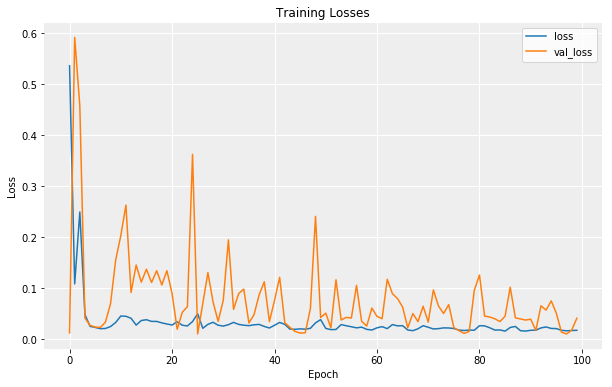

In [521]:
f,a = simple_ax(figsize=(10,6))
a.plot(history.history['loss'], label='loss')
a.plot(history.history['val_loss'], label='val_loss')
a.set_title('Training Losses')
a.set_xlabel('Epoch')
a.set_ylabel('MSE Loss')
plt.legend()
plt.show()

In [537]:
##### SAVE MODEL #####
model.save('model/model0.h5')

# Predict Future Prices

In [ ]:
#### LOAD MODEL #####
model = load_model('model/model0.h5')

RMSE:  0.573355936265


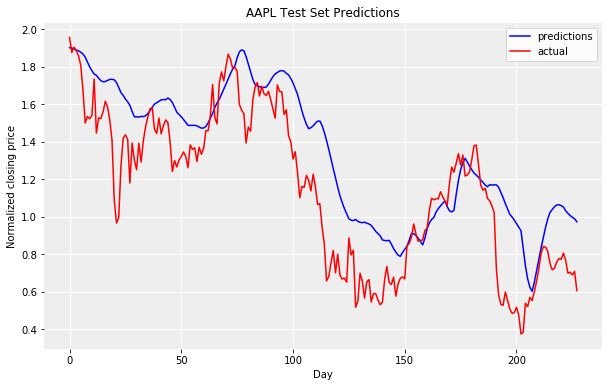

In [536]:
# predict test set
predictions = model.predict(X_test)
print "RMSE: ", np.sqrt(np.mean((predictions-y_test)**2))

f, a = simple_ax(figsize=(10,6))
a.plot(predictions, c='b', label='predictions')
a.plot(y_test, c='r', label='actual')
a.set_ylabel('Normalized closing price')
a.set_xlabel('Day')
a.set_title('AAPL Test Set Predictions')
plt.legend()
plt.show()

In [539]:
def predict_days(startday, days_topredict, data, model):
    ''' starting from startday predict days_topredict stock prices '''
    curr_data = data[startday,:,:]
    predictions = []
    for day in range(days_topredict):
        prediction = model.predict(curr_data.reshape(1,curr_data.shape[0],curr_data.shape[1]))[0][0]
        predictions.append(prediction)
        new_row = curr_data[-1,:]
        new_row[0] = prediction
        curr_data = np.vstack((curr_data[1:,:], new_row))
    return predictions

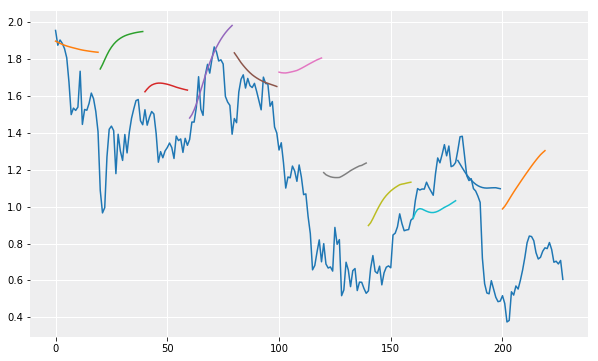

In [542]:
days = 20
f, a = simple_ax(figsize=(10,6))
a.plot(y_test)
for segment in range(int(len(y_test)/days)):
    predictions = predict_days(segment*days, days, X_test, model)
    a.plot(range(segment*days, segment*days+days), predictions)
plt.show()